# Assignment 3

# Import the necessary libraries

In [638]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Question 1: We saw the perceptron algorithm in Lecture 15. I want you to implement this algorithm, and use it to classify banknotes as forged or authentic in this dataset. In particular,
# (a) Code up the perceptron algorithm described on slide 7 of Lecture 15 using the same notation as in the slides. [10 points]

In [639]:
def perceptron(data, init_, learn_rate=1, n_iter=50):
    '''
    Implementation of perceptron algorithm using stochastic sub-gradient descent
    Input:
    data: Data to train the model
    init_: Value for initializing the weight vector w
    learn_rate: learning rate to run our gradient descent algorithm
    n_iter: number of iterations
    tol: tolerance to stop iterations when the update becomes close to 0
    
    Output:
    Optimal w for the given dataset
    
    Logic:
    Run until convergence:
        chose a random sample from given data
        find the prediction on this sample using the current w
        if the prediction is wrong, then update w using the rule: w(t+1) = w(t) + y_n.x_n
    '''
    
    # initialize w with init_
    w = init_

    # initialize a correct classification counter, this will be used for convergence criteria
    correct_classification = 0

    # run the update for n_iter iterations
    for i in range(n_iter):

        # select a random data point from input dataset
        random_sample = data[np.random.choice(data.shape[0], size=1, replace=False)][0]

        # extract the training attributes and labels from the random sample
        X = random_sample[:-1]
        y = random_sample[-1]  # the true label is the last value in sample

        if(y*np.dot(w, X) < 0):
            correct_classification += 1

        # update w if the current prediction is wrong, i.e. the sign of actual value and predicted value is different
        if(y*np.dot(w, X) < 0):

            # reset the correct_classification counter
            correct_classification = 0
            
            # calculate the delta (the update to be done on weight vector w)
            delta = learn_rate * y * X

            # update w
            w += delta
        
        # break the loop if if the classification for last 10 iterations is correct
        if(correct_classification > 10):
            print('Converged at Iteration: ', i)
            break

    return w

# (b) Write functions to make predictions using the algorithm for the banknotes dataset. Preprocess the dataset to handle missing and anomalous data. [10 points]

# (i) Define the function to find the predicted label for a given input

In [640]:
def predict(x, w):
    '''
    This function returns the prediction for the data sample x and returns the predicted label.
    Logic:
        y_n = w.T * x_n
    '''
    return 1 if np.dot(w, x) > 0 else -1

# (ii) Load banknotes authentication dataset

In [641]:
def load_data(data_path, file_name, column_names):
    '''
    Function to load the dataset as a dataframe
    This function takes the datafile location and column names as input and returns the dataframe
    '''
    return pd.read_csv(data_path+file_name, sep=",", names=column_names)


data_path = './dataset/'
file_name = 'data_banknote_authentication.txt'
column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

banknotes_data = load_data(data_path, file_name, column_names)
banknotes_data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# (iii) Exploratory Data Analysis and Preprocessing

In [642]:
banknotes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [643]:
banknotes_data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


## We can see that the dataset does not contain any missing values, so missing data imputation is not required.
## Also, the dataset does not contain any categorical features

# (iv) Standardize the feature columns

In [644]:
# split the dataframe into data and target columns since we don't need to normalize the target column
data = banknotes_data.drop('class', axis=1)
target = banknotes_data['class'].copy()
    
# do min-max normalization of all the features in the dataframe data
data = (data - data.min()) / (data.max() - data.min())

# concatenate the price column to the features
banknotes_data = pd.concat([data, target], axis=1)

# (v) Some general preprocessing
- Convert the dataframe to a numpy array, 
- Change the target column values from 0/1 to -1/+1, this would allow us to run the exact algorithm as mentioned in the lecture slides
- Append a column of 1's in the dataframe. This would allow us to include a bias term in parameters of w.

In [645]:
# convert the data to a numpy array as it will be easier to work with numpy array
banknotes_data = banknotes_data.to_numpy()

# change the label 0 to -1, so that we will have +1/-1 labels in our data
for i in range(banknotes_data.shape[0]):
    if(banknotes_data[i, -1] == 0):
        banknotes_data[i, -1] = -1

# The below line appends an extra dimension of ones to the data samples
banknotes_data = np.c_[np.ones(banknotes_data.shape[0]), banknotes_data]

# shuffle the rows in data
np.random.shuffle(banknotes_data)

# Split the Data into Train and Test Set

In [646]:
# shuffle the sequence of samples
np.random.shuffle(banknotes_data)

# take 20% of samples as test data
test_data_size = int(0.2 * len(banknotes_data))

# extract train and test data
test_data = banknotes_data[:test_data_size-1]
train_data = banknotes_data[test_data_size:]

print(train_data.shape, test_data.shape)

(1098, 6) (273, 6)


# (c) Train the algorithm on the dataset using cross-validation and report cross-validated test set error [10 points]

In [647]:
def perceptron_loss(data, w):
    '''
    This function calculates the perceptron loss on the input data and optimal w
    Logic:
        L(w) = sum over all data samples ( max{0, -y_n * W.T * x_n} )
    '''

    # extract the data features and labels from input data
    X = data[:, :-1]
    y = data[:, -1]

    loss = 0

    for i in range(X.shape[0]):
        loss += max(0, -y[i]*np.dot(w, X[i]))

    return loss

# Define the KFoldCrossValidation Function

In [648]:
def KFoldCrossValidation(data, init_w, n_folds=4):
    '''
    This functions take the training data as input and number of folds to be
    used for the kFoldCrossValidation. It returns the average error on validation set
    '''
    
    # size of single data split for the given number of folds
    piece_size = int(data.shape[0] / n_folds)
    
    # copy the data into a seperate variable
    data_copy = np.copy(data)
    
    # shuffle the rows in the data
    np.random.shuffle(data_copy)  # shuffle happens inplace

    error = 0

    min_error = float('inf')
    
    # iterate over each piece of data and calculate average RMSE over the validation set
    for i in range(0, n_folds):
        
        # create an array of indexes for validation data
        # for ex: when i=0 the indexes for validation set would be [0...39]
        # when i=1 the indexes for validation set would be [40...79] and so on.
        val_data_indexes = np.arange(i*piece_size, (i+1)*piece_size)
        
        # extract the validation data based on the above indexes
        val_data = data_copy[val_data_indexes]
        
        # extract the training data by removing the rows belonging to the indexes of validation data
        train_data = np.delete(data_copy, val_data_indexes, axis=0)

        w = perceptron(train_data, init_w, learn_rate=1, n_iter=10000)

        # find the error on this split
        error_i = perceptron_loss(val_data, w)

        # update the best_w if the current error is lower
        if(error_i < min_error):
            min_error = error_i
            best_w = w

        # sum all the values of errors on each validation set formed in the splits
        error += error_i
        
    # return the average error on validation set and the best_w
    return error/n_folds, best_w

## Run the cross validation on the perceptron algorithm and find the best w

In [649]:
# set initial w to all one's, the size of w will be equal to the number of dimensions of the data
init_w = np.ones((banknotes_data.shape[1]-1))

# find the optimal w using cross validation
avg_error, best_w = KFoldCrossValidation(banknotes_data, init_w, n_folds=10)
print('The average validation set error on 10 fold cross validation =', avg_error)

print('The best w is = ', best_w)

The average validation set error on 10 fold cross validation = 1.1556651103432425
The best w is =  [ 29.         -20.57515965 -22.98918587 -23.25081823  -0.15607905]


# (d) Ensure you use a held out validation set and report F1 score on the held out set for your best model [5 points]

# Define the function to calculate F1 Score

To calculate the F1 Score we need to calculate precision and recall using number of true positives, false positives, and false negative.

* true_positive = number of correct classification of positive samples <br>
* false_positive = number of incorrect classification of negative samples <br>
* false_negative = number of incorrect classification of negative samples

<br>

$$ Precision = \frac {true\_positive} {true\_positive + false\_positive} $$

<br>

$$ Recall = \frac {true\_positive} {true\_positive + false\_negative} $$

<br>

The F1 Score is the harmonic mean of precision and recall, 

<br>

$$ f1score = \frac {2*precision*recall} {precision+recall} $$

In [650]:
def f1_score(y, y_pred):
    '''
    This function calculates the f1_score given actual labels and predicted labels
    '''

    # true_positive is the number of positive samples that our model correctly classified as positive
    true_positive = sum((y == 1) & (y_pred == 1))
    # false_positive is the number of negative samples that our model incorrectly classified as positive
    false_positive = sum((y == -1) & (y_pred == 1))
    # false_negative is the number of positive samples that our model incorrectly classified as negative
    false_negative = sum((y == 1) & (y_pred == -1))
    
    # calculate precision and recall
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)

    # return the f1 score, which is the harmonic mean of precision and recall
    return 2*precision*recall / (precision + recall)

In [651]:
# find the predictions for the test data
y_pred = []
for x in test_data:
    y_pred.append(predict(x[:-1], best_w))

# convert to pandas series (this will make it easier to calculate f1 score based on the function we defined above)
y = pd.Series(test_data[:, -1].astype(int).tolist())
y_pred = pd.Series(y_pred)

print('The F1 Score on Test Data for the Best Model is', f1_score(y, y_pred))

The F1 Score on Test Data for the Best Model is 0.9769230769230769


# Question 2: In Lecture 14, we saw how we can use MCMC sampling to approximate Bayesian posteriors when the prior and likelihood distributions are not conjugate. Let’s consider a simple demonstration of MCMC sampling in a setting where conjugacy is actually possible – normal likelihoods with a known population variance, for which the prior is another normal distribution.

# (a) Write a function to calculate the Bayesian posterior probability given 50 new data samples drawn from a normal distribution with mean 10 and SD 5, assuming a normal prior with mean 25 and s.d. 5. Plot the pdfs of the prior, the likelihood and the posterior distributions. Explain how you derive the likelihood from the data. [15 points]

# (i) Derivation of the Likelihood Function

The likelihood for a sample $x$ can be written as:

$$
\begin{align}
P(x|\mu, \sigma^2) = \frac {1} {\sqrt{2 \pi \sigma^2}} e^{\frac{-(x-\mu)^2}{2 \sigma^2}}
\end{align}
$$

<br>

For $n$ i.i.d. samples $x_1, x_2, ..., x_n$, we can calculate the likelihood as following:

$$
\begin{align}
P(x_1, x_2, ..., x_n|\mu, \sigma^2) &= \prod_{i=1}^{n} \frac {1} {\sqrt{2 \pi \sigma^2}} e^{\frac{-(x_i-\mu)^2}{2 \sigma^2}} \\
&= \left( \frac {1} {\sqrt{2 \pi \sigma^2}} \right)^n e^{\frac{-\sum_{i=1}^n (x_i-\mu)^2}{2 \sigma^2}} \\
&\propto e^{\frac{-\sum_{i=1}^n (x_i-\mu)^2}{2 \sigma^2}}
\end{align}
$$

<br>

Now, we will do some mathematical rearrangement and rewrite the above equation in a different way,

$$
\begin{align}
P(x_1, x_2, ..., x_n|\mu, \sigma^2) &\propto e^{\frac{-\sum_{i=1}^n (x_i-\mu)^2}{2 \sigma^2}} \\
&\propto e^{\frac {- \left(\sum_{i=1}^n x_i^2 + n \mu^2 - 2 \mu \sum_{i=1}^n x_i \right)} {2 \sigma^2}} \\
&\propto e^{\frac {-n} {2 \sigma^2} \left( \mu^2 - 2\mu \frac{\sum_{i=1}^n x_i}{n} + \frac{\sum_{i=1}^n x_i^2} {n}  \right)} \\
&\propto e^{\frac {-1} {2 \left( \sigma^2 / n \right)} \left( \mu^2 - 2\mu \bar{x} + \frac{\sum_{i=1}^n x_i^2} {n}  \right)} \\
&\propto e^{\frac {-1} {2 \left( \sigma^2 / n \right)} \left( \mu^2 - 2\mu \bar{x} + \frac{\sum_{i=1}^n x_i^2} {n}  \right)}
\end{align}
$$

We known that the product of normal distributions is also a normal distribution, so the form of above equation will be similar to $ \propto e^{\frac {-1} {2 \sigma^2} (\mu - \mu_L)^2} $ which can be written as $ e^{\frac {-1} {2 \sigma^2} \left( \mu^2 - 2\mu\mu_L + \mu_L^2 \right)} $

On comparing this with the result we obtained above, we can see that $\mu_L = \bar{x}$ and $\sigma_L^2 = \frac {\sigma^2} {n}$ where $\mu_L$ is the mean and $\sigma_L^2$ is the variance of likelihood distribution.

<br>

Therefore, the probability density function for the likelihood is $\mathcal{N}(\bar {x}, \frac{\sigma^2}{n})$

# (ii) Calculating the Posterior Probability

In order to calculate the bayesian posterior probability we will apply baye's theorem and insert the likelihood and prior. 

<br>

The statement to calculate the the bayesian posterior probability $P(\theta|y)$ can be written as:

$$ P(\theta|y) = \frac {P(\theta) * P(y|\theta)}{P(y)} $$

&emsp;&emsp; where $P(\theta)$ is the prior, $P(y|\theta)$ is the likelihood and $P(y)$ is the marginal likelihood.

Since, it is given that prior is a normal distribution, let's take prior as $\mathcal{N}(\mu_{prior}, \sigma_{prior}^2)$

<br>

$$
\begin{align}
Posterior &= Prior * Likelihood \\

&\propto exp \left[\frac{-(\mu - \mu_{prior})^2}{2\sigma_{prior}^2} \right] * exp \left[\frac{-n(\mu - \bar{x})^2}{2\sigma^2}\right] \\

&\propto exp \left[\frac{-(\mu^2 -2\mu\mu_{prior} + \mu_{prior}^2)}{2\sigma_{prior}^2} \right] * exp \left[\frac{-n(\mu^2 -2\mu\bar{x} + \bar{x}^2)}{2\sigma^2}\right] \\

&\propto exp \left[\frac{-(\mu^2 -2\mu\mu_{prior} + \mu_{prior}^2)}{2\sigma_{prior}^2} \right] * exp \left[\frac{-n(\mu^2 -2\mu\bar{x} + \bar{x}^2)}{2\sigma^2}\right] \\

&\propto exp \left[\frac{-1}{2} \mu^2 \left( \frac{1}{\sigma_{prior}^2} + \frac{n}{\sigma^2} \right) - 2 \mu \left( \frac{\mu_{prior}}{\sigma_{prior}^2} + \frac{n \bar{x}}{\sigma^2} \right)   \right] \\


\end{align}
$$

We known that the product of normal distributions is also a normal distribution, so the form of above equation will be similar to $ \propto e^{\frac {-1} {2 \sigma^2} (\mu - \mu_{post})^2} $ which can be written as $ e^{\frac {-1} {2 \sigma^2} \left( \mu^2 - 2\mu\mu_{post} + \mu_{post}^2 \right)} $

On comparing this with the result we obtained above, we can see that $\mu_{post} = \sigma_{posterior}^2 \left(\frac {\mu_{prior} \sigma^2 + n\bar{x} \sigma_{prior}^2}{\sigma^2 \sigma_{prior}^2} \right)$ and $\sigma_{post}^2 = \frac{\sigma^2 \sigma_{prior}^2} {\sigma^2 + n\sigma_{prior}^2}$ where $\mu_{post}$ is the mean and $\sigma_{post}^2$ is the variance of posterior distribution.

Therefore, the probability density function for the posterior is $\mathcal{N}(\sigma_{posterior}^2 \left(\frac {\mu_{prior} \sigma^2 + n\bar{x} \sigma_{prior}^2}{\sigma^2 \sigma_{prior}^2} \right), \frac{\sigma^2 \sigma_{prior}^2} {\sigma^2 + n\sigma_{prior}^2})$

# (iii) Define function for calculating the norm

$\mathcal{N}(x|\mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp \left[ \frac{(x - \mu)^2} {2 \sigma^2} \right]$

In [652]:
def norm(x, mean, variance): 
    '''
    This function calculates and returns the norm using data, mean and its variance
    '''
    return np.exp(-np.square(x-mean)/(2*variance)) / np.sqrt(2*np.pi*variance)

# (iv) Plot the pdf of prior, data generator, likelihood, and posterior

Likelihood 9.415571632984689 0.7818564807386692
Posterior 9.787546281425936 0.7724693148882209


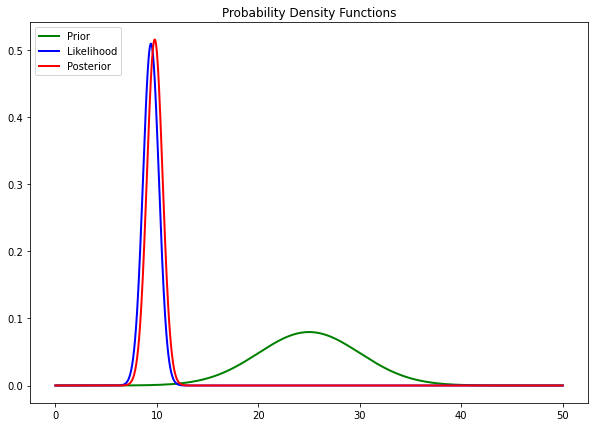

In [653]:
# Define figure-size, labels, and figure-title
plt.figure(figsize=(10, 7))
plt.xlabel('')
plt.ylabel('')
plt.title('Probability Density Functions')

# Generate list of numbers for plotting pdf of prior
mean_prior = 25
std_prior = 5

# Generate 50 samples for the likelihood using mean as 10 and std as 5
data_samples = np.random.normal(loc=10, scale=5, size=50)
data_mean = np.mean(data_samples)
data_std = np.std(data_samples)

# Calculate the mean and std for likelihood using the expression derived above
mean_likelihood = data_mean
std_likelihood = data_std / np.sqrt(len(data_samples))
print('Likelihood', mean_likelihood, std_likelihood)

# Calculate the mean and std for posterior using the expression derived above
variance_posterior = (data_std**2 * std_prior**2) / (data_std**2 + len(data_samples)*std_prior**2)
std_posterior = np.sqrt(variance_posterior)
mean_posterior = variance_posterior * ((mean_prior * data_std**2 + len(data_samples) * data_mean * std_prior**2) / (std_prior**2 * data_std**2))

print('Posterior', mean_posterior, std_posterior)

# Generate number to plot the pdfs
x_plot = np.linspace(start=0, stop=50, num=1000)

# Plot the prior, likelihood and posterior
plt.plot(x_plot, norm(x_plot, mean=mean_prior, variance=std_prior**2), color='g', linewidth=2)
plt.plot(x_plot, norm(x_plot, mean=mean_likelihood, variance=std_likelihood**2), color='b', linewidth=2)
plt.plot(x_plot, norm(x_plot, mean=mean_posterior, variance=variance_posterior), color='r', linewidth=2)

# Add legend to the figure
plt.legend(["Prior", "Likelihood", "Posterior"], loc ="upper left")

# Show the plot
plt.show()

# (b) Implement the Metropolis algorithm from the lecture slides to estimate the posterior distribution given the same prior and data and show that it converges to the analytic posterior by plotting a histogram of samples from the distribution alongside the analytic posterior distribution. Assume whatever SD (width) you want for the proposal distribution. [15 points]

# Define the function to implement the Metropolis-Hastings

In [654]:
def metropolis_hastings(parameter_init=0, sigma_proposal=1, n_iter=1000, k=1000, tol=1):

    tic = time.time()

    # create an empty list to store the sampled parameters
    parameters_list = list()

    # initialize parameter variable with initial parameter passed to the function
    parameter = parameter_init

    # add the initial parameter also to the list
    parameters_list.append(parameter)

    # now, we will use prior and posterior to calculate initial posterior value
    
    # calculate the prior using mean = 25 and std = 5 (variance = 25)
    prior = norm(parameter, 25, 25)

    # calculate the likelihood by multiplying 50 samples generated from normal distribution
    likelihood = np.prod([norm(x, parameter, sigma_proposal**2) for x in data_samples])
                
    # calculate the posterior
    posterior_current = prior * likelihood

    # initialize a variable to record the iteration number at which our algo converges
    convergence_iter = 0

    # run the algo for n_iter iterations
    for i in range(n_iter):

        # select a random sample from jump distribution (consider normal distribution)
        parameter_jump = np.random.normal(loc=parameter, scale=sigma_proposal)

        # calculate the prior for the proposed parameter, given mean = 25 and std = 5 (variance = 25)
        prior = norm(parameter_jump, 25, 25)

        # calculate the likelihood by multiplying pdf of 50 samples generated from normal distribution
        # and use the proposed parameter as the mean
        likelihood = np.prod([norm(x, parameter_jump, sigma_proposal**2) for x in data_samples])
                
        # calculate the posterior for the current iteration
        posterior_next = prior * likelihood

        # find the ratio of proposed posterior to the current posterior and compare it with 'a'
        r = min(1, (posterior_next / posterior_current))

        # select a random number between 0 and 1
        a = np.random.uniform(0, 1)

        if(r > a):
            # accept the current value and update parameter
            parameter = parameter_jump

            # update the proposed posterior for the next iteration
            posterior_current = posterior_next

        # add the current mean to the list of means
        parameters_list.append(parameter)

        # convergence criteria check
        if(i > k):

            # extract last k samples
            last_k_samples = parameters_list[-k:]
            
            # if the changes in mean of last k samples is below tolerance then break iterations
            if(np.all(np.abs(last_k_samples - np.mean(last_k_samples))) <= tol):
                
                # record the iteration number
                convergence_iter = i
                print('Converged at iteration: ', i, ' Proposal Width = ', sigma_proposal)
                
                break

    print('Time Taken to Converge: ', time.time() - tic)

    # If the algo ran for all iterations return the number of iters it ran (this value will be used later)
    if(convergence_iter == 0):
        convergence_iter = 1000000

    return parameters_list, convergence_iter

# Run the Metropolis Algorithm for our Data

In [655]:
# run the metropolis algo with some sigma value and iterations
parameters, convergence_iter = metropolis_hastings(parameter_init=0, sigma_proposal=2, n_iter=100000, k=800, tol=0.8)

Time Taken to Converge:  41.094358682632446


# Compare the Histogram of Samples and Calculated Posterior from the Previous Question

Parameters Mean =  9.720552439156176 STD =  0.704558402896102
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


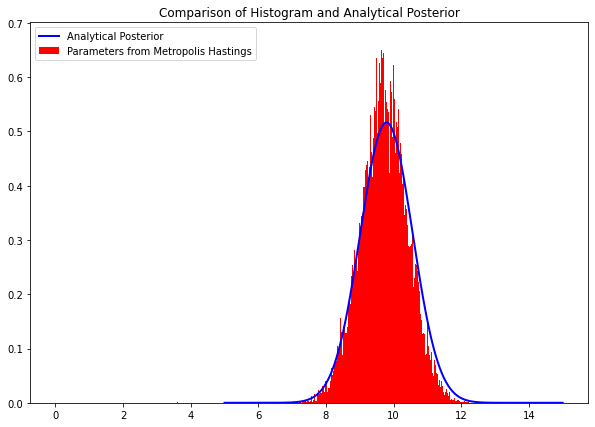

In [656]:
# Define figure-size, labels, and figure-title
plt.figure(figsize=(10, 7))
plt.title('Comparison of Histogram and Analytical Posterior')

# Plot the histogram of samples (skip the first few values as they might not be much accurate)
plt.hist(parameters, bins=500, color='r', density=True)
print('Parameters Mean = ', np.mean(parameters), 'STD = ', np.std(parameters))

# Generate values for plotting the posterior pdf
x_plot = np.linspace(start=5, stop=15, num=1000)
print('Posterior Mean = ', mean_posterior, 'STD = ', std_posterior)

# Plot the analytical posterior
plt.plot(x_plot, norm(x_plot, mean=mean_posterior, variance=variance_posterior), color='b', linewidth=2)

# Add legend to the figure
plt.legend(["Analytical Posterior", "Parameters from Metropolis Hastings"], loc ="upper left")
plt.show()

# (c) How does the speed of convergence of the sampling depend on the proposal width? Is there an optimal proposal width that would work best? Demonstrate the consequences of using sub-optimal proposal width and terminating sampling too soon. [10 points]

# Run the Metropolis-Hastings for Different Proposal Widths and Find the Optimal Proposal Width

C:\Users\tripa\AppData\Local\Temp/ipykernel_17856/1753896537.py:45: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1, (posterior_next / posterior_current))


Time Taken to Converge:  48.428038358688354
Parameters Mean =  -173.71617765350123 STD =  85.89864495175844
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


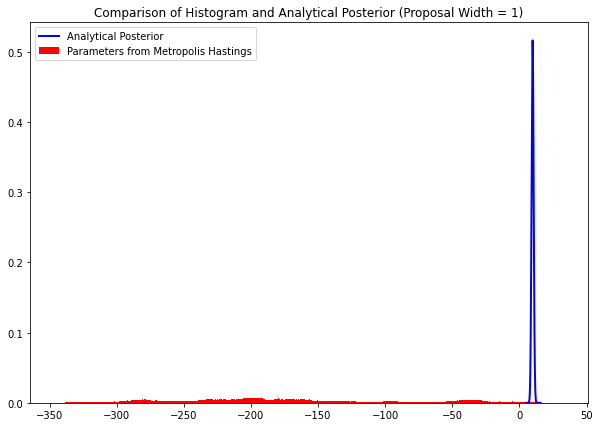

C:\Users\tripa\AppData\Local\Temp/ipykernel_17856/1753896537.py:45: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1, (posterior_next / posterior_current))
C:\Users\tripa\AppData\Local\Temp/ipykernel_17856/1753896537.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  r = min(1, (posterior_next / posterior_current))


Time Taken to Converge:  46.705073833465576
Parameters Mean =  9.411406967409098 STD =  1.1895882243915372
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


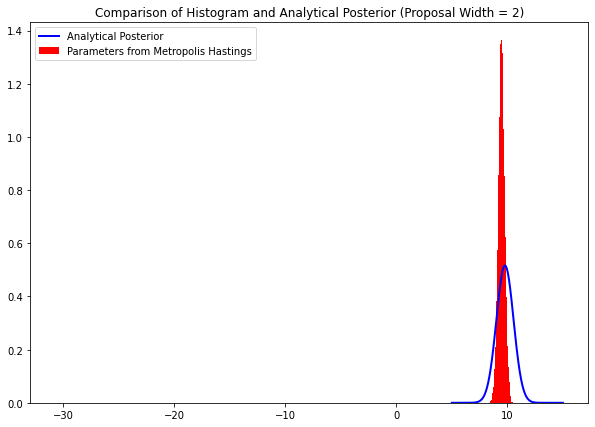

Time Taken to Converge:  44.91166567802429
Parameters Mean =  9.530567583645535 STD =  0.42772566595794637
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


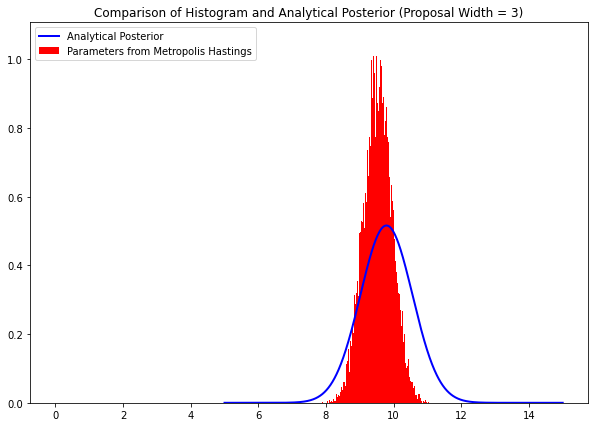

Time Taken to Converge:  44.1748685836792
Parameters Mean =  9.611764595246447 STD =  0.5666204060049815
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


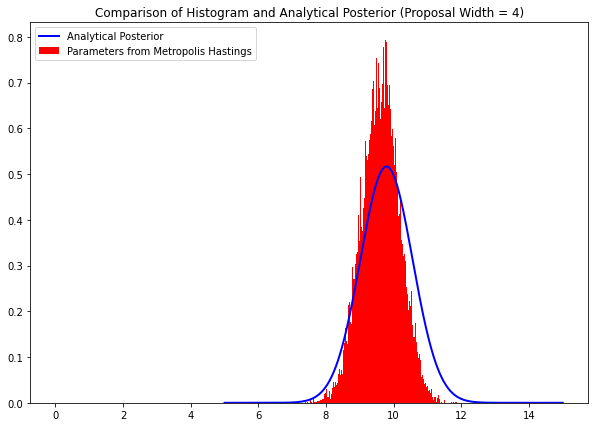

Time Taken to Converge:  44.05892586708069
Parameters Mean =  9.71125475495339 STD =  0.6997538580201971
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


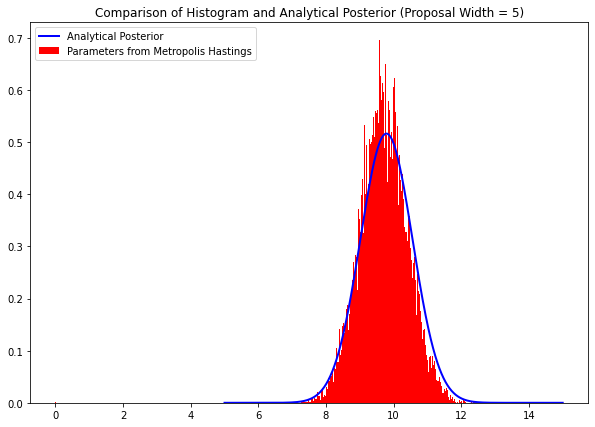

The proposal width with fastest convergence is =  1


In [661]:
# create a list to record the iteration where it converges
convergence_iter_list = list()

# run for different proposal widths
for proposal_width in range(1, 6):

    parameters, convergence_iter = metropolis_hastings(parameter_init=0, sigma_proposal=proposal_width, n_iter=100000, k=1000, tol=0.8)
    convergence_iter_list.append(convergence_iter)

    # Define figure-size, labels, and figure-title
    plt.figure(figsize=(10, 7))
    plt.title('Comparison of Histogram and Analytical Posterior (Proposal Width = '+str(proposal_width)+')')

    # Plot the histogram of samples (skip the first few values as they might not be much accurate)
    plt.hist(parameters, bins=500, color='r', density=True)
    print('Parameters Mean = ', np.mean(parameters), 'STD = ', np.std(parameters))

    # Generate values for plotting the posterior pdf
    x_plot = np.linspace(start=5, stop=15, num=1000)
    print('Posterior Mean = ', mean_posterior, 'STD = ', std_posterior)

    # Plot the analytical posterior
    plt.plot(x_plot, norm(x_plot, mean=mean_posterior, variance=variance_posterior), color='b', linewidth=2)

    # Add legend to the figure
    plt.legend(["Analytical Posterior", "Parameters from Metropolis Hastings"], loc ="upper left")
    plt.show()


# Find the proposal width that converged earliest
optimal_proposal_width = convergence_iter_list.index(min(convergence_iter_list)) + 1
print('The proposal width with fastest convergence is = ', optimal_proposal_width)

# Note that in the above figures, the proposal width = 5 gives the best approximation of posterior. We can consider it as the optimal proposal width

# Consequence of using Sub-Optimal Proposal Width

The histogram of samples would not converge to the posterior approximation even after huge number of sampling iterations

C:\Users\tripa\AppData\Local\Temp/ipykernel_17856/1753896537.py:45: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1, (posterior_next / posterior_current))


Time Taken to Converge:  45.830381870269775
Parameters Mean =  -55.46767559418243 STD =  75.89173036827441
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


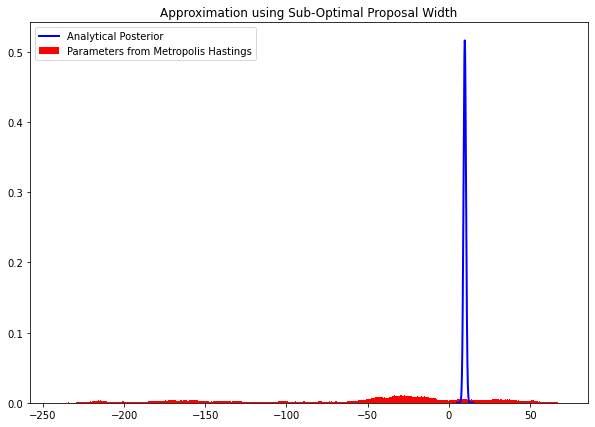

In [659]:
parameters, convergence_iter = metropolis_hastings(parameter_init=0, sigma_proposal=0.8, n_iter=100000, k=1000, tol=0.8)

# Define figure-size, labels, and figure-title
plt.figure(figsize=(10, 7))
plt.title('Approximation using Sub-Optimal Proposal Width')

# Plot the histogram of samples (skip the first few values as they might not be much accurate)
plt.hist(parameters, bins=500, color='r', density=True)
print('Parameters Mean = ', np.mean(parameters), 'STD = ', np.std(parameters))

# Generate values for plotting the posterior pdf
x_plot = np.linspace(start=5, stop=15, num=1000)
print('Posterior Mean = ', mean_posterior, 'STD = ', std_posterior)

# Plot the analytical posterior
plt.plot(x_plot, norm(x_plot, mean=mean_posterior, variance=variance_posterior), color='b', linewidth=2)

# Add legend to the figure
plt.legend(["Analytical Posterior", "Parameters from Metropolis Hastings"], loc ="upper left")
plt.show()

# Consequence of Terminating Sampling Too Early

The histogram of samples would be incomplete and the approximation would not be accurate

C:\Users\tripa\AppData\Local\Temp/ipykernel_17856/1753896537.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  r = min(1, (posterior_next / posterior_current))


Time Taken to Converge:  0.38297009468078613
Parameters Mean =  9.409560174682904 STD =  0.6100762375310695
Posterior Mean =  9.787546281425936 STD =  0.7724693148882209


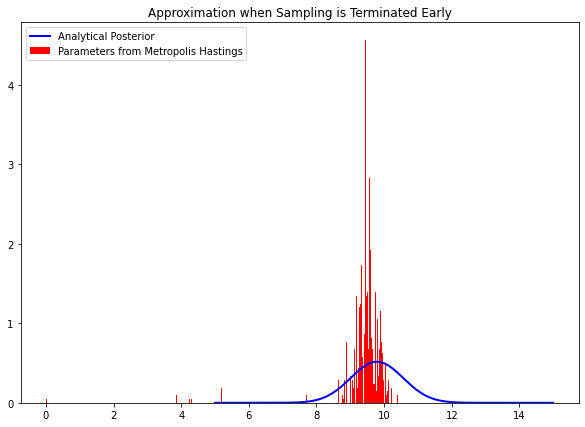

In [660]:
# run the algo for only 1000 iterations
parameters, convergence_iter = metropolis_hastings(parameter_init=0, sigma_proposal=2, n_iter=1000, k=1000, tol=0.8)

# Define figure-size, labels, and figure-title
plt.figure(figsize=(10, 7))
plt.title('Approximation when Sampling is Terminated Early')

# Plot the histogram of samples (skip the first few values as they might not be much accurate)
plt.hist(parameters, bins=500, color='r', density=True)
print('Parameters Mean = ', np.mean(parameters), 'STD = ', np.std(parameters))

# Generate values for plotting the posterior pdf
x_plot = np.linspace(start=5, stop=15, num=1000)
print('Posterior Mean = ', mean_posterior, 'STD = ', std_posterior)

# Plot the analytical posterior
plt.plot(x_plot, norm(x_plot, mean=mean_posterior, variance=variance_posterior), color='b', linewidth=2)

# Add legend to the figure
plt.legend(["Analytical Posterior", "Parameters from Metropolis Hastings"], loc ="upper left")
plt.show()

------------------------------------------------------------------------------------------ End of Assignment --------------------------------------------------------------------------------------------